/var/folders/_4/nh2v7vsj6dxgjzgdkc_krcnh0000gn/T/ipykernel_52038/3884321440.py:11: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  large_train_dataset = df.replace(['Yes', 'No'], [1, 0])


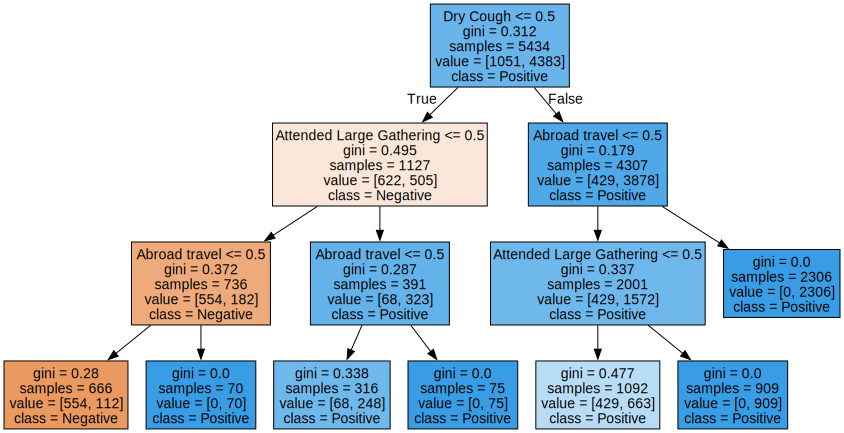

In [9]:
import pandas as pd
import random
random.seed(0)

df = pd.read_csv("Covid Dataset.csv")
df = df[['Dry Cough', 'Attended Large Gathering', 'Abroad travel', 'COVID-19']]

from sklearn import tree
import graphviz

large_train_dataset = df.replace(['Yes', 'No'], [1, 0])
large_train_gt = large_train_dataset['COVID-19']
large_train_dataset = large_train_dataset.drop(columns=['COVID-19'])

# Max Depth None
DT = tree.DecisionTreeClassifier(max_depth=None, min_samples_split=2, random_state=0)

DT.fit(large_train_dataset,large_train_gt)

Target = ['Negative','Positive']

# DOT data
DTRep = tree.export_graphviz(DT, out_file=None, 
                                feature_names= large_train_dataset.columns,
                                class_names= Target,
                                filled=True)

# Draw graph
DTgraphmax = graphviz.Source(DTRep, format="png") 
DTgraphmax

In [7]:
pd.set_option("display.max_rows", 5)
df

,Dry Cough,Attended Large Gathering,Abroad travel,COVID-19
0,Yes,No,No,Yes
1,Yes,Yes,No,Yes
...,...,...,...,...
5432,Yes,No,No,No
5433,Yes,No,No,No


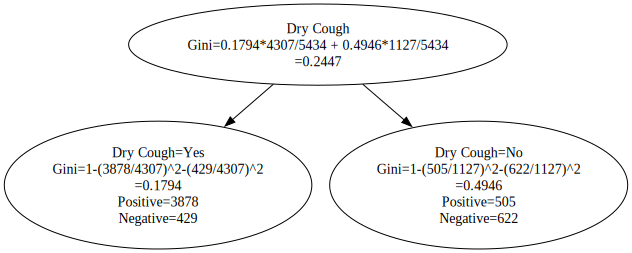

In [11]:
labels = ("Yes", "No")

def get_gini_impurity(df, feature_key, class_key):
    ginis = []
    cnts = []
    results = [feature_key]
    for feature_label in labels:
        sub_df = df[df[feature_key] == feature_label]
        label_cnts = [len(sub_df[sub_df[class_key] == class_label])
        for class_label in labels]
        results.append((feature_label, label_cnts))
        label_cnt_sum = sum(label_cnts)
        if label_cnt_sum == 0:
            gini = 1
        else:
            gini = 1 - sum((label_cnt / label_cnt_sum) * (label_cnt / label_cnt_sum)
                       for label_cnt in label_cnts)
        ginis.append(gini)
        results.append(gini)
        cnts.append(label_cnt_sum)
    cnt_sum = sum(cnts)
    total_gini = sum(gini * cnt / cnt_sum for gini, cnt in zip(ginis, cnts))
    results.append(total_gini)
    return results

# let's calculate the Gini Impurity

import graphviz

all_ginis = [get_gini_impurity(df, column, "COVID-19")
             for column in df.columns if column != "COVID-19"]
all_ginis = sorted(all_ginis, key=lambda x:x[5])

def draw_gini(item):
    dot = graphviz.Digraph()
    root = "{}\nGini={:.4f}*{}/{} + {:.4f}*{}/{}\n={:.4f}".format(item[0], item[2], (item[1][1][0] + item[1][1][1]), (item[1][1][0] + item[1][1][1] + item[3][1][0] + item[3][1][1]), item[4], (item[3][1][0] + item[3][1][1]), (item[1][1][0] + item[1][1][1] + item[3][1][0] + item[3][1][1]), item[5])
    left = "{}={}\nGini=1-({}/{})^2-({}/{})^2\n={:.4f}\nPositive={}\nNegative={}".format(item[0], item[1][0], item[1][1][0], (item[1][1][0] + item[1][1][1]), item[1][1][1], (item[1][1][0] + item[1][1][1]), item[2], item[1][1][0], item[1][1][1])
    right = "{}={}\nGini=1-({}/{})^2-({}/{})^2\n={:.4f}\nPositive={}\nNegative={}".format(item[0], item[3][0], item[3][1][0], (item[3][1][0] + item[3][1][1]), item[3][1][1], (item[3][1][0] + item[3][1][1]), item[4], item[3][1][0], item[3][1][1])
    dot.node(root)
    dot.node(left)
    dot.node(right)
    dot.edge(root, left)
    dot.edge(root, right)
    return dot

draw_gini(all_ginis[0])